<a href="https://colab.research.google.com/github/mrdbourke/pytorch-deep-learning/blob/main/extras/exercises/06_pytorch_transfer_learning_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 06. PyTorch Transfer Learning Exercises

Welcome to the 06. PyTorch Transfer Learning exercise template notebook.

There are several questions in this notebook and it's your goal to answer them by writing Python and PyTorch code.

> **Note:** There may be more than one solution to each of the exercises, don't worry too much about the *exact* right answer. Try to write some code that works first and then improve it if you can.

## Resources and solutions

* These exercises/solutions are based on [section 06. PyTorch Transfer Learning](https://www.learnpytorch.io/06_pytorch_transfer_learning/) of the Learn PyTorch for Deep Learning course by Zero to Mastery.

**Solutions:** 

Try to complete the code below *before* looking at these.

* See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/ueLolShyFqs).
* See an example [solutions notebook for these exercises on GitHub](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/solutions/06_pytorch_transfer_learning_exercise_solutions.ipynb).

## 1. Make predictions on the entire test dataset and plot a confusion matrix for the results of our model compared to the truth labels. 
* **Note:** You will need to get the dataset and the trained model/retrain the model from notebook 06 to perform predictions.
* Check out [03. PyTorch Computer Vision section 10](https://www.learnpytorch.io/03_pytorch_computer_vision/#10-making-a-confusion-matrix-for-further-prediction-evaluation) for ideas.

In [20]:
# Import required libraries/code
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

from torch import nn
from torchvision import transforms, datasets

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

In [2]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Get data 

In [16]:
import os
import requests
import zipfile

from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
food_data_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it... 
if food_data_path.is_dir():
    print(f"{food_data_path} directory exists.")
else:
    print(f"Did not find {food_data_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...") 
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / "pizza_steak_sushi.zip")

# Setup Dirs
train_dir = food_data_path / "train"
test_dir = food_data_path / "test"

data\pizza_steak_sushi directory exists.


### Prepare data

In [4]:
# Create a transforms pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

In [5]:
# Create training and testing DataLoader's as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=simple_transform, # resize, convert images to between 0 & 1 and normalize them
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x213c10f8190>,
 ['pizza', 'steak', 'sushi'])

### Get and prepare a pretrained model

In [6]:
# Setup the model with pretrained weights and send it to the target device 
model_0 = torchvision.models.efficientnet_b0(pretrained=True).to(device)
# model_0 # uncomment to output (it's very long)

d:\pytorch-test\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\pytorch-test\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model_0.features.parameters():
    param.requires_grad = False

In [8]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model_0.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1280, 
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

### Train model

In [9]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=0.001)

In [10]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
model_0_results = engine.train(model=model_0,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0910 | train_acc: 0.4336 | test_loss: 0.9077 | test_acc: 0.5294
Epoch: 2 | train_loss: 0.8804 | train_acc: 0.7734 | test_loss: 0.7859 | test_acc: 0.7642
Epoch: 3 | train_loss: 0.7750 | train_acc: 0.8086 | test_loss: 0.7240 | test_acc: 0.7737
Epoch: 4 | train_loss: 0.7355 | train_acc: 0.7109 | test_loss: 0.6432 | test_acc: 0.9072
Epoch: 5 | train_loss: 0.6373 | train_acc: 0.7969 | test_loss: 0.6237 | test_acc: 0.8864
[INFO] Total training time: 175.887 seconds


### Make predictions on the entire test dataset with the model

In [11]:
# TODO
from tqdm.auto import tqdm

test_preds = []
test_preds_probs = []
test_true = []
wrong_preds = []

model_0.eval()
with torch.inference_mode():
    for X, y in tqdm(test_dataloader):
        X, y = X.to(device), y.to(device)
        preds_logits = model_0(X)
        preds_probs = preds_logits.softmax(dim=1)
        preds_labels = preds_probs.argmax(dim=1)

        test_preds_probs.append(preds_probs.cpu())
        test_preds.append(preds_labels.cpu())
        test_true.append(y.cpu())

test_preds = torch.cat(test_preds)
test_true = torch.cat(test_true)
test_preds_probs = torch.cat(test_preds_probs)

  0%|          | 0/3 [00:00<?, ?it/s]

### Make a confusion matrix with the test preds and the truth labels

Need the following libraries to make a confusion matrix:
* torchmetrics - https://torchmetrics.readthedocs.io/en/stable/
* mlxtend - http://rasbt.github.io/mlxtend/

In [12]:
# See if torchmetrics exists, if not, install it
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

Exception ignored in: <function _ConnectionBase.__del__ at 0x00000213B9E2B380>
Traceback (most recent call last):
  File "C:\Users\killi\AppData\Local\Programs\Python\Python311\Lib\multiprocessing\connection.py", line 133, in __del__
    self._close()
  File "C:\Users\killi\AppData\Local\Programs\Python\Python311\Lib\multiprocessing\connection.py", line 282, in _close
    _CloseHandle(self._handle)
OSError: [WinError 6] The handle is invalid


mlxtend version: 0.23.1


In [13]:
# Import mlxtend upgraded version
import mlxtend 
print(mlxtend.__version__)
assert int(mlxtend.__version__.split(".")[1]) >= 19 # should be version 0.19.0 or higher

0.23.1


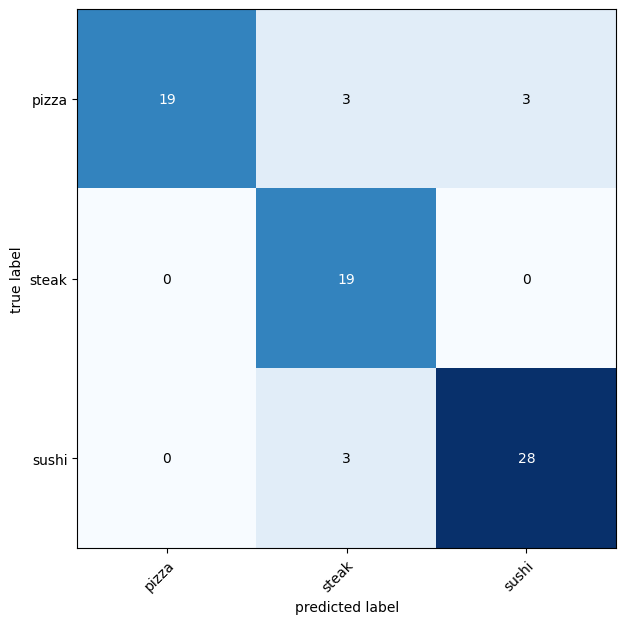

In [14]:
# TODO
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=test_preds,
                         target=test_true)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy 
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10, 7)
);

## 2. Get the "most wrong" of the predictions on the test dataset and plot the 5 "most wrong" images. You can do this by:
* Predicting across all of the test dataset, storing the labels and predicted probabilities.
* Sort the predictions by *wrong prediction* and then *descending predicted probabilities*, this will give you the wrong predictions with the *highest* prediction probabilities, in other words, the "most wrong".
* Plot the top 5 "most wrong" images, why do you think the model got these wrong?

You'll want to:
* Create a DataFrame with sample, label, prediction, pred prob
* Sort DataFrame by correct (does label == prediction)
* Sort DataFrame by pred prob (descending)
* Plot the top 5 "most wrong" image predictions

In [16]:
# Get the tensor with values which don't match (Misclassification)
wrong_preds = torch.ne(test_preds, test_true)

# Get the indices of the misclassified examples
wrong_preds_indices = wrong_preds.nonzero().squeeze()

# Get the class labels by using masking technique
wrong_preds_labels = [class_names[label] for label in test_preds[wrong_preds_indices]]
true_labels = [class_names[label] for label in test_true[wrong_preds_indices]]

# Get the probabiities of the misclassified examples
wrong_probs = [round(test_preds_probs[idx].max().item(), 3) for idx in wrong_preds_indices]

wrong_preds_labels, true_labels, wrong_probs

(['steak',
  'sushi',
  'steak',
  'sushi',
  'steak',
  'sushi',
  'steak',
  'steak',
  'steak'],
 ['pizza',
  'pizza',
  'pizza',
  'pizza',
  'pizza',
  'pizza',
  'sushi',
  'sushi',
  'sushi'],
 [0.4, 0.431, 0.407, 0.41, 0.415, 0.44, 0.48, 0.405, 0.548])

In [17]:
from pathlib import  Path

test_data_paths = [str(path) for path in Path("data/pizza_steak_sushi/test").glob("*/*")]

In [18]:
misclassified_data = [test_data_paths[idx] for idx in wrong_preds_indices]

In [19]:
df = {
    "samples": misclassified_data,
    "true_labels": true_labels,
    "predicted_labels": wrong_preds_labels,
    "probabilities": wrong_probs
}

In [20]:
import pandas as pd

df = pd.DataFrame(df)

top_5_misclassified_samples = df.sort_values(by=["probabilities"], ascending=False).head(5)

In [52]:
top_5_misclassified_samples

,samples,true_labels,predicted_labels,probabilities
8,data\pizza_steak_sushi\test\sushi\684266.jpg,sushi,steak,0.548
6,data\pizza_steak_sushi\test\sushi\1172255.jpg,sushi,steak,0.480
5,data\pizza_steak_sushi\test\pizza\971934.jpg,pizza,sushi,0.440
1,data\pizza_steak_sushi\test\pizza\2508636.jpg,pizza,sushi,0.431
4,data\pizza_steak_sushi\test\pizza\648055.jpg,pizza,steak,0.415


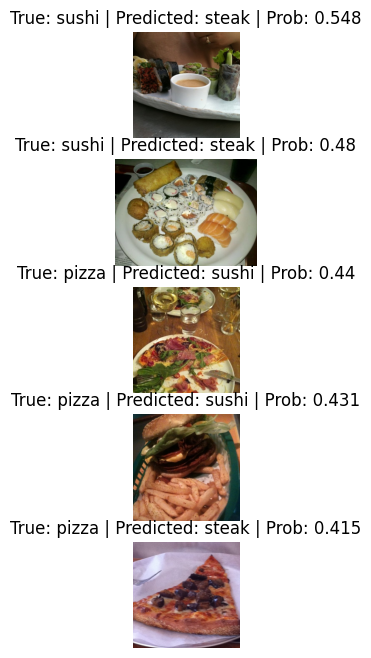

In [60]:
from PIL import Image 

plt.figure(figsize=(16, 8))
rows = 5
cols = 1

for i, (index, row) in enumerate(top_5_misclassified_samples.iterrows(), start=1):        
    image = Image.open(row['samples'])
    true_label = row['true_labels']
    predicted_label = row['predicted_labels']
    prob = row['probabilities']

    plt.subplot(rows, cols, i)
    plt.imshow(image)
    plt.title(f"True: {true_label} | Predicted: {predicted_label} | Prob: {prob}")
    plt.axis(False)
    

## 3. Predict on your own image of pizza/steak/sushi - how does the model go? What happens if you predict on an image that isn't pizza/steak/sushi?
* Here you can get an image from a website like http://www.unsplash.com to try it out or you can upload your own.

In [81]:
# TODO: Get an image of pizza/steak/sushi
foods = [
    ('pizza', 'https://www.simplyrecipes.com/thmb/pjYMLcsKHkr8D8tYixmaFNxppPw=/1500x0/filters:no_upscale():max_bytes(150000):strip_icc()/__opt__aboutcom__coeus__resources__content_migration__simply_recipes__uploads__2019__09__easy-pepperoni-pizza-lead-3-8f256746d649404baa36a44d271329bc.jpg'),
    ('steak', 'https://diethood.com/wp-content/uploads/2021/02/ribeye-steak-5.jpg'),
    ('sushi', 'https://www.allrecipes.com/thmb/SGDpqApdYsAJ0m6ofejv9DZUS50=/1500x0/filters:no_upscale():max_bytes(150000):strip_icc()/24228-Sushi-roll-ddmfs-2x1-2914-5dfc8a65325b432e8834ea5cac82b8bf.jpg')
]

for label, image_url in foods:
    with open(f"{label}.jpg", 'wb') as f:
        request = requests.get(image_url)
        f.write(request.content)

In [82]:
pizza_image = simple_transform(Image.open("pizza.jpg")).unsqueeze(dim=0)
steak_image = simple_transform(Image.open("steak.jpg")).unsqueeze(dim=0)
sushi_image = simple_transform(Image.open("sushi.jpg")).unsqueeze(dim=0)

custom_images = [pizza_image, steak_image, sushi_image]

model_0.eval()
with torch.inference_mode():
    for image in custom_images:
        pred = model_0(image.to(device)).softmax(dim=1).argmax(dim=1)
        print(pred)

tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([1], device='cuda:0')


In [87]:
# TODO: Get an image of not pizza/steak/sushi
not_foods = [
    ('chair', 'https://interwood.pk/cdn/shop/products/conte_executive_chair_visual.jpg?v=1699176820'),
    ('frog', 'https://images.pexels.com/photos/70083/frog-macro-amphibian-green-70083.jpeg?cs=srgb&dl=pexels-pixabay-70083.jpg&fm=jpg'),
    ('aeroplane', 'https://t3.ftcdn.net/jpg/00/01/47/28/360_F_1472821_kMjcU0El8NkcU0k7zNtlVTU0Fl8W2l.jpg')
]

for label, image_url in not_foods:
    with open(f"{label}.jpg", 'wb') as f:
        request = requests.get(image_url)
        f.write(request.content)

In [88]:
chair_image = simple_transform(Image.open("chair.jpg")).unsqueeze(dim=0)
frog_image = simple_transform(Image.open("frog.jpg")).unsqueeze(dim=0)
aeroplane_image = simple_transform(Image.open("aeroplane.jpg")).unsqueeze(dim=0)

custom_images = [chair_image, frog_image, aeroplane_image]

model_0.eval()
with torch.inference_mode():
    for image in custom_images:
        pred = model_0(image.to(device)).softmax(dim=1).argmax(dim=1)
        print(pred)

tensor([0], device='cuda:0')
tensor([1], device='cuda:0')
tensor([2], device='cuda:0')


## 4. Train the model from section 4  in notebook 06 part 3 for longer (20 epochs should do), what happens to the performance?

* See the model in notebook 06 part 3 for reference: https://www.learnpytorch.io/06_pytorch_transfer_learning/#3-getting-a-pretrained-model

In [89]:
# TODO: Recreate a new model 
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

summary(model=model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

In [90]:
for param in model.features.parameters():
    param.requires_grad = False

In [91]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1280, 
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

In [92]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [93]:
# TODO: Train the model for 20 epochs

# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=20,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0910 | train_acc: 0.4336 | test_loss: 0.9077 | test_acc: 0.5294
Epoch: 2 | train_loss: 0.8804 | train_acc: 0.7734 | test_loss: 0.7859 | test_acc: 0.7642
Epoch: 3 | train_loss: 0.7750 | train_acc: 0.8086 | test_loss: 0.7240 | test_acc: 0.7737
Epoch: 4 | train_loss: 0.7355 | train_acc: 0.7109 | test_loss: 0.6432 | test_acc: 0.9072
Epoch: 5 | train_loss: 0.6373 | train_acc: 0.7969 | test_loss: 0.6237 | test_acc: 0.8864
Epoch: 6 | train_loss: 0.5873 | train_acc: 0.8984 | test_loss: 0.5556 | test_acc: 0.8864
Epoch: 7 | train_loss: 0.5262 | train_acc: 0.9180 | test_loss: 0.5322 | test_acc: 0.9072
Epoch: 8 | train_loss: 0.5612 | train_acc: 0.8008 | test_loss: 0.5276 | test_acc: 0.9176
Epoch: 9 | train_loss: 0.5667 | train_acc: 0.7930 | test_loss: 0.4977 | test_acc: 0.9176
Epoch: 10 | train_loss: 0.4693 | train_acc: 0.8125 | test_loss: 0.4229 | test_acc: 0.8655
Epoch: 11 | train_loss: 0.4747 | train_acc: 0.8867 | test_loss: 0.4245 | test_acc: 0.9176
Epoch: 12 | train_l

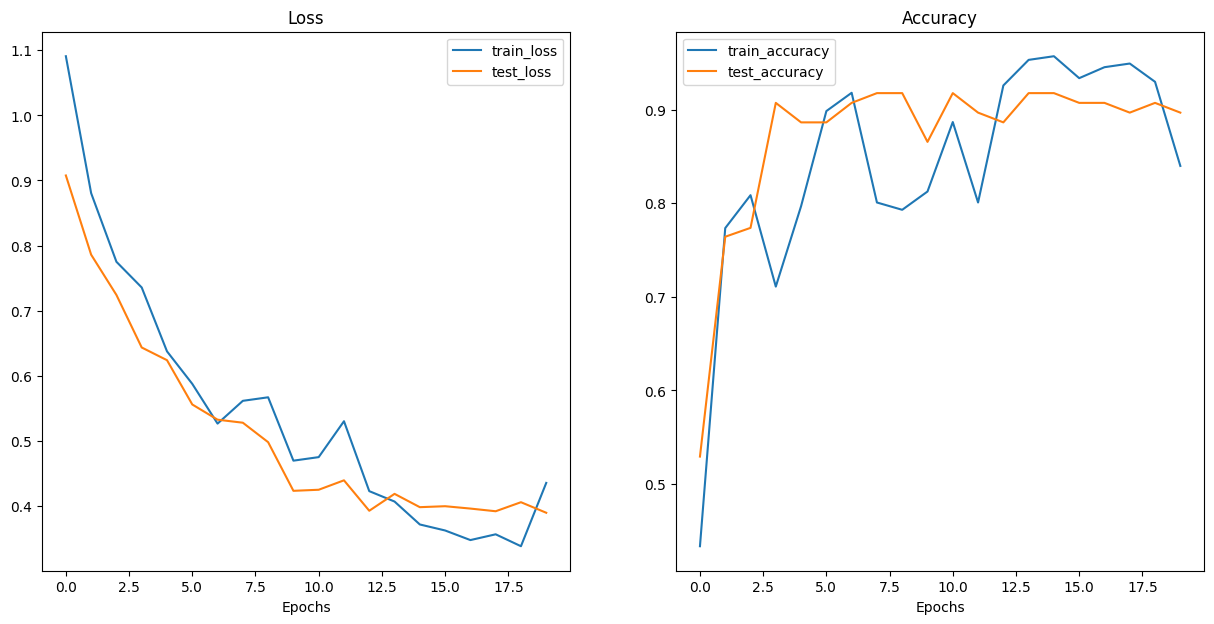

In [94]:
# Get the plot_loss_curves() function from helper_functions.py, download the file if we don't have it
try:
    from helper_functions import plot_loss_curves
except:
    print("[INFO] Couldn't find helper_functions.py, downloading...")
    with open("helper_functions.py", "wb") as f:
        import requests
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves

# Plot the loss curves of our model
plot_loss_curves(results)

## 5. Train the model from section 4 above with more data, say 20% of the images from Food101 of Pizza, Steak and Sushi images.
* You can find the [20% Pizza, Steak, Sushi dataset](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi_20_percent.zip) on the course GitHub. It was created with the notebook [`extras/04_custom_data_creation.ipynb`](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb). 


### Get 20% data

In [102]:
import os
import requests
import zipfile

from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi_20_percent"
image_data_zip_path = "pizza_steak_sushi_20_percent.zip"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download pizza, steak, sushi data
    with open(data_path / image_data_zip_path, "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / image_data_zip_path, "r") as zip_ref:
        print("Unzipping pizza, steak, sushi 20% data...") 
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / image_data_zip_path)

# Setup Dirs
train_dir_20_percent = image_path / "train"
test_dir_20_percent = image_path / "test"

train_dir_20_percent, test_dir_20_percent

data\pizza_steak_sushi_20_percent directory exists.


(WindowsPath('data/pizza_steak_sushi_20_percent/train'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test'))

### Create DataLoaders

In [103]:
# Create a transforms pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

In [104]:
# Create training and testing DataLoader's as well as get a list of class names
train_dataloader_20_percent, test_dataloader_20_percent, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent,
                                                                                                     test_dir=test_dir_20_percent,
                                                                                                     transform=simple_transform, # resize, convert images to between 0 & 1 and normalize them
                                                                                                     batch_size=32) # set mini-batch size to 32

train_dataloader_20_percent, test_dataloader_20_percent, class_names

(<torch.utils.data.dataloader.DataLoader at 0x213c18a9b50>,
 ['pizza', 'steak', 'sushi'])

### Get a pretrained model

In [105]:
# TODO
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

for param in model.features.parameters():
    param.requires_grad = False

In [106]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1280, 
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

In [107]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### Train a model with 20% of the data

In [108]:
# TODO

# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
results = engine.train(model=model,
                       train_dataloader=train_dataloader_20_percent,
                       test_dataloader=test_dataloader_20_percent,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9802 | train_acc: 0.5458 | test_loss: 0.6526 | test_acc: 0.9102
Epoch: 2 | train_loss: 0.6961 | train_acc: 0.8208 | test_loss: 0.5329 | test_acc: 0.8818
Epoch: 3 | train_loss: 0.5852 | train_acc: 0.8604 | test_loss: 0.4564 | test_acc: 0.8943
Epoch: 4 | train_loss: 0.4506 | train_acc: 0.8938 | test_loss: 0.4038 | test_acc: 0.9006
Epoch: 5 | train_loss: 0.4449 | train_acc: 0.8979 | test_loss: 0.3772 | test_acc: 0.9102
Epoch: 6 | train_loss: 0.4176 | train_acc: 0.8458 | test_loss: 0.3528 | test_acc: 0.9068
Epoch: 7 | train_loss: 0.4284 | train_acc: 0.8354 | test_loss: 0.3192 | test_acc: 0.9193
Epoch: 8 | train_loss: 0.4063 | train_acc: 0.8438 | test_loss: 0.3203 | test_acc: 0.9040
Epoch: 9 | train_loss: 0.3405 | train_acc: 0.8646 | test_loss: 0.3124 | test_acc: 0.9074
Epoch: 10 | train_loss: 0.3531 | train_acc: 0.8812 | test_loss: 0.2694 | test_acc: 0.9381
[INFO] Total training time: 702.781 seconds


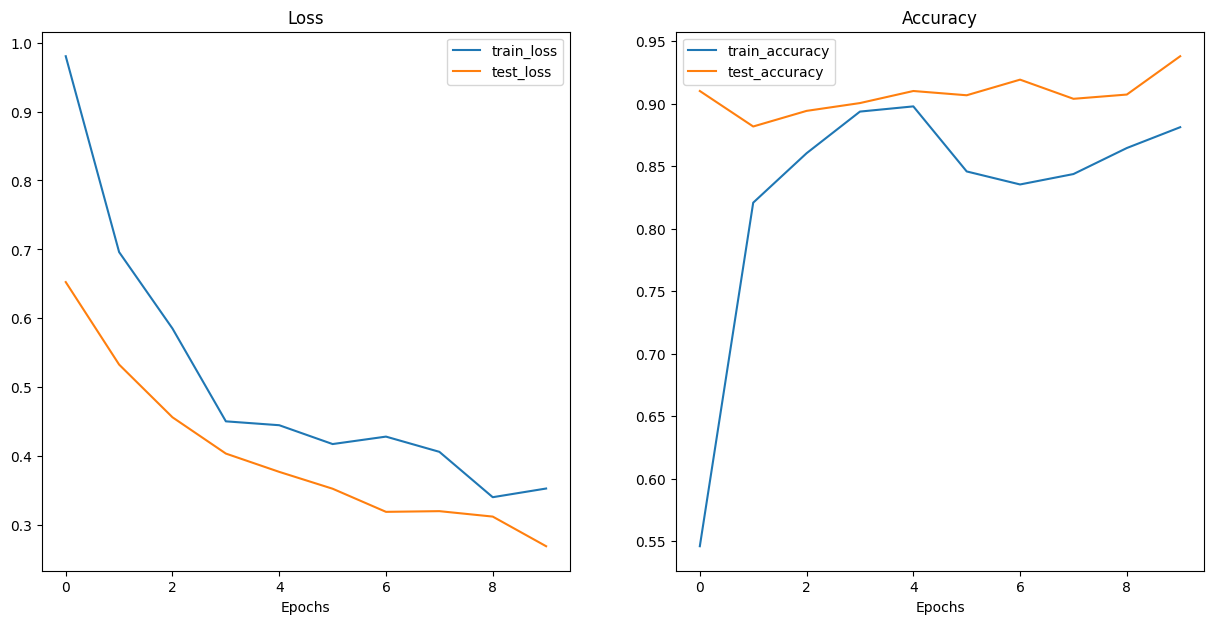

In [109]:
# Get the plot_loss_curves() function from helper_functions.py, download the file if we don't have it
try:
    from helper_functions import plot_loss_curves
except:
    print("[INFO] Couldn't find helper_functions.py, downloading...")
    with open("helper_functions.py", "wb") as f:
        import requests
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves

# Plot the loss curves of our model
plot_loss_curves(results)

## 6. Try a different model from [`torchvision.models`](https://pytorch.org/vision/stable/models.html) on the Pizza, Steak, Sushi data, how does this model perform?
* You'll have to change the size of the classifier layer to suit our problem.
* You may want to try an EfficientNet with a higher number than our B0, perhaps `torchvision.models.efficientnet_b2()`?
  * **Note:** Depending on the model you use you will have to prepare/transform the data in a certain way.

### 6.1. Load the dataset

In [18]:
# Create training and testing DataLoader's as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=preprocess,
                                                                               batch_size=32)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x22edf0a3d90>,
 ['pizza', 'steak', 'sushi'])

### 6.2. Load the pre-trained model.

In [22]:
# TODO
from torchvision.models import mobilenet_v3_large, MobileNet_V3_Large_Weights

# Initialize the Weight Transforms
weights = MobileNet_V3_Large_Weights.DEFAULT
preprocess = weights.transforms()

# Initialize model
model = mobilenet_v3_large(weights=weights).to(device)

In [29]:
summary(model=model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
MobileNetV3 (MobileNetV3)                                    [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 960, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 16, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 16, 112, 112]   432                  True
│    │    └─BatchNorm2d (1)                                  [32, 16, 112, 112]   [32, 16, 112, 112]   32                   True
│    │    └─Hardswish (2)                                    [32, 16, 112, 112]   [32, 16, 112, 112]   --                   --
│    └─InvertedResidual (1)                                  [32, 16, 112, 112]   [32, 16, 112

#### 6.2.1. Freeze the feature extractor.

In [33]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model.features.parameters():
    param.requires_grad = False

#### 6.2.2. Modify the classifier block.

In [31]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model.classifier = torch.nn.Sequential(
    torch.nn.Linear(in_features=960, out_features=1280, bias=True),
    torch.nn.Hardswish(),
    torch.nn.Dropout(p=0.8, inplace=True), 
    torch.nn.Linear(in_features=1280, 
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

In [32]:
summary(model=model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
MobileNetV3 (MobileNetV3)                                    [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 960, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 16, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 16, 112, 112]   (432)                False
│    │    └─BatchNorm2d (1)                                  [32, 16, 112, 112]   [32, 16, 112, 112]   (32)                 False
│    │    └─Hardswish (2)                                    [32, 16, 112, 112]   [32, 16, 112, 112]   --                   --
│    └─InvertedResidual (1)                                  [32, 16, 112, 112]   [32, 

### 6.3 Train the model.

In [34]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [35]:
# TODO

# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9543 | train_acc: 0.5312 | test_loss: 1.0067 | test_acc: 0.4773
Epoch: 2 | train_loss: 0.7073 | train_acc: 0.6758 | test_loss: 0.6978 | test_acc: 0.6326
Epoch: 3 | train_loss: 0.3739 | train_acc: 0.8984 | test_loss: 0.8018 | test_acc: 0.6420
Epoch: 4 | train_loss: 0.4949 | train_acc: 0.8242 | test_loss: 0.6390 | test_acc: 0.6941
Epoch: 5 | train_loss: 0.4341 | train_acc: 0.8008 | test_loss: 0.6811 | test_acc: 0.6828
Epoch: 6 | train_loss: 1.0168 | train_acc: 0.8125 | test_loss: 0.6105 | test_acc: 0.7348
Epoch: 7 | train_loss: 0.3134 | train_acc: 0.8281 | test_loss: 0.6029 | test_acc: 0.7756
Epoch: 8 | train_loss: 0.2940 | train_acc: 0.9297 | test_loss: 0.6845 | test_acc: 0.7235
Epoch: 9 | train_loss: 1.6138 | train_acc: 0.7852 | test_loss: 0.4382 | test_acc: 0.8163
Epoch: 10 | train_loss: 1.0379 | train_acc: 0.7734 | test_loss: 0.5271 | test_acc: 0.7860
[INFO] Total training time: 279.708 seconds


### 6.4. Evaluate the results.

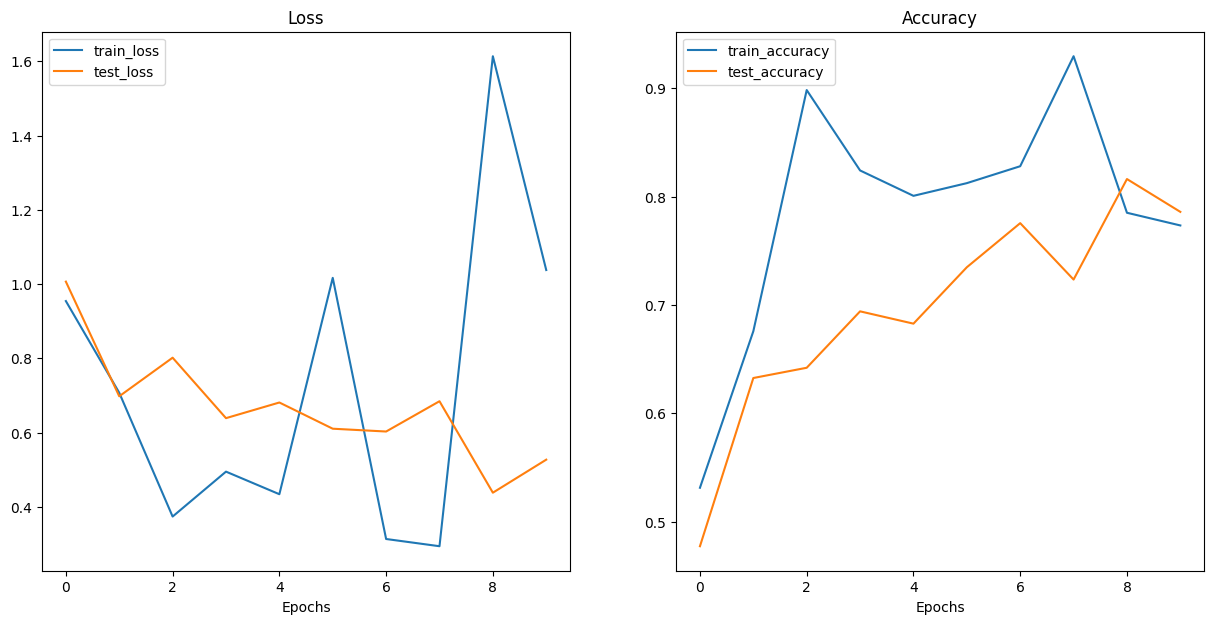

In [36]:
# Get the plot_loss_curves() function from helper_functions.py, download the file if we don't have it
try:
    from helper_functions import plot_loss_curves
except:
    print("[INFO] Couldn't find helper_functions.py, downloading...")
    with open("helper_functions.py", "wb") as f:
        import requests
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves

# Plot the loss curves of our model
plot_loss_curves(results)

In [38]:
from tqdm.auto import tqdm

test_preds = []
test_preds_probs = []
test_true = []
wrong_preds = []

model.eval()
with torch.inference_mode():
    for X, y in tqdm(test_dataloader):
        X, y = X.to(device), y.to(device)
        preds_logits = model(X)
        preds_probs = preds_logits.softmax(dim=1)
        preds_labels = preds_probs.argmax(dim=1)

        test_preds_probs.append(preds_probs.cpu())
        test_preds.append(preds_labels.cpu())
        test_true.append(y.cpu())

test_preds = torch.cat(test_preds)
test_true = torch.cat(test_true)
test_preds_probs = torch.cat(test_preds_probs)

Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "C:\Users\killi\AppData\Local\Programs\Python\Python311\Lib\multiprocessing\queues.py", line 239, in _feed


  0%|          | 0/3 [00:15<?, ?it/s]

    reader_close()
  File "C:\Users\killi\AppData\Local\Programs\Python\Python311\Lib\multiprocessing\connection.py", line 178, in close
    self._close()
  File "C:\Users\killi\AppData\Local\Programs\Python\Python311\Lib\multiprocessing\connection.py", line 282, in _close
    _CloseHandle(self._handle)
OSError: [WinError 6] The handle is invalid

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\killi\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 1045, in _bootstrap_inner
    self.run()
  File "d:\pytorch-test\.venv\Lib\site-packages\ipykernel\ipkernel.py", line 761, in run_closure
    _threading_Thread_run(self)
  File "C:\Users\killi\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 982, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\killi\AppData\Local\Programs\Python\Python311\Lib\multiprocessing\queues.py", line 271, in _feed
    queue_sem.release()
ValueE

Exception ignored in: <function _ConnectionBase.__del__ at 0x0000022ED7FDF420>
Traceback (most recent call last):
  File "C:\Users\killi\AppData\Local\Programs\Python\Python311\Lib\multiprocessing\connection.py", line 133, in __del__
    self._close()
  File "C:\Users\killi\AppData\Local\Programs\Python\Python311\Lib\multiprocessing\connection.py", line 282, in _close
    _CloseHandle(self._handle)
OSError: [WinError 6] The handle is invalid


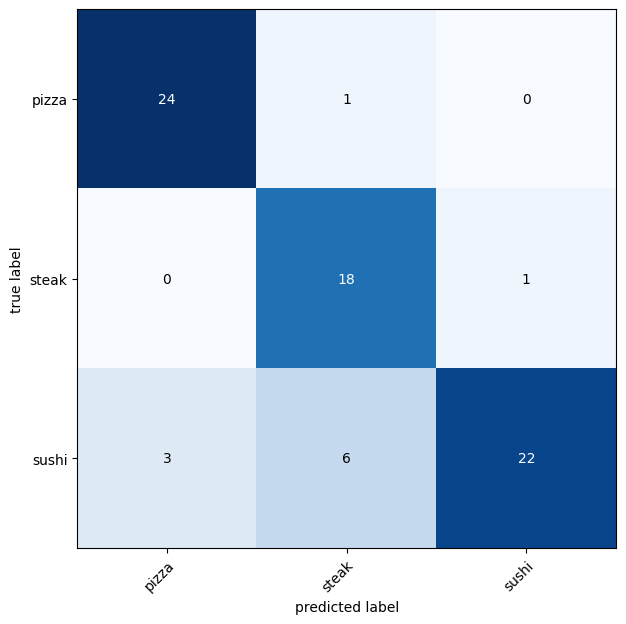

In [39]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=test_preds,
                         target=test_true)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy 
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10, 7)
)